In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from typing import Optional
import matplotlib

sns.set_context("notebook", font_scale=1)
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.sans-serif'] = 'Nimbus Sans'

%matplotlib inline
%config InlineBackend.figure_formats = ['retina']

from IPython.display import display

%matplotlib inline

def restore_minor_ticks_log_plot(
    ax: Optional[plt.Axes] = None, n_subticks=9
) -> None:
    """For axes with a logrithmic scale where the span (max-min) exceeds
    10 orders of magnitude, matplotlib will not set logarithmic minor ticks.
    If you don't like this, call this function to restore minor ticks.

    Args:
        ax:
        n_subticks: Number of Should be either 4 or 9.

    Returns:
        None
    """
    if ax is None:
        ax = plt.gca()
    # Method from SO user importanceofbeingernest at
    # https://stackoverflow.com/a/44079725/5972175
    locmaj = mpl.ticker.LogLocator(base=10, numticks=1000)
    ax.xaxis.set_major_locator(locmaj)
    locmin = mpl.ticker.LogLocator(
        base=10.0, subs=np.linspace(0, 1.0, n_subticks + 2)[1:-1], numticks=1000
    )
    ax.xaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

# 3 Johnson et al. (2017) Excitatory neurons RNAseq

In [2]:
genes = pd.read_csv("annotation/mus_musculus/genes.bed", sep="\t", index_col=3, header=None)

# Because Boxer et al. (2020) uses the same assembly, get the CArepeat overlap file from there
_genes = pd.read_csv("methylation/GSE128178_mRNA_seq_CAn.tsv", sep="\t", header=None)
can = _genes.groupby(3).sum()[9]
genes["gene length"] = genes[2] - genes[1]
genes["CAn bases"] = can
genes["percentage CAn"] = (genes["CAn bases"]/genes["gene length"])*100

In [3]:
def get_l2fc(genes, file, bins=30):
    df = pd.read_csv(file, sep="\t", index_col=0)
    l2fc = pd.concat([genes, df], axis=1)
    l2fc = l2fc[l2fc["padj"]<0.05].dropna()
    l2fc["percentage CAn bins"] = pd.qcut(l2fc["percentage CAn"], 30, duplicates="drop")
    return l2fc

def mean_std_err(df, groupby="percentage CAn bins"):
    mean = df.groupby(groupby).mean()
    std = df.groupby(groupby).sem()
    return mean, std

def plot(ax, l2fc, logx=True, groupby="percentage CAn bins", ylabel=True):
    mean, std = mean_std_err(l2fc, groupby=groupby)
    r = l2fc[[groupby.split(" bins")[0], "log2FoldChange"]].dropna().corr(method="spearman").values[0][1]
    ax.errorbar(x=mean[groupby.split(" bins")[0]].values,
                y=mean["log2FoldChange"].values,
                xerr=std[groupby.split(" bins")[0]].values,
                yerr=std["log2FoldChange"].values,
                fmt="o", color="black", markersize=6, markeredgecolor="white", linewidth=1)    
    ax.set_xlabel("")
    ax.axhline(y=0, color="black", linestyle="dashed", linewidth=1)
    props = dict(boxstyle='round', facecolor='white', alpha=0.75)
    ax.text(0.05, 0.95, r"$\mathregular{R^2}=$"+"{:.2f}".format(r*r), transform=ax.transAxes, va='top', bbox=props)
    
    if ylabel:    
        ax.set_ylabel(r"$\mathregular{log_2}$" " fold change")
    
    if logx:
        ax.set_xscale("log")
        restore_minor_ticks_log_plot(ax)    

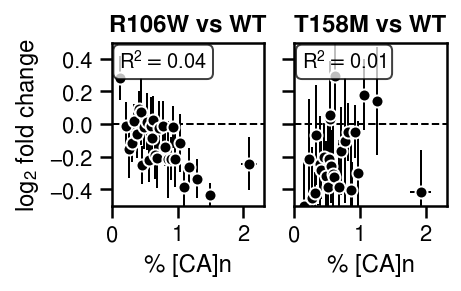

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(3, 1.5), sharey=True, sharex=True)
for ax, file, ylabel, title in zip(axes, 
    ["counts/GSE83474.DESeq2.results/R106W_vs_WT.tsv", "counts/GSE83474.DESeq2.results/T158M_vs_WT.tsv"], [True, False],
    ["R106W vs WT", "T158M vs WT"]):
    l2fc = get_l2fc(genes, file)
    plot(ax, l2fc, logx=False, ylabel=ylabel)
    ax.set_title(title, fontweight="bold")
    ax.set_xlabel("% [CA]n")
axes[0].set_xticks([0,1,2])
axes[0].set_ylim(-.5, .5)
_ = axes[0].set_yticks([-.4, -.2, 0, .2, .4])
fig.savefig("plots/R106W_T158M_vs_WT.pdf")